In [1]:
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr

(20000, 28, 28, 2)


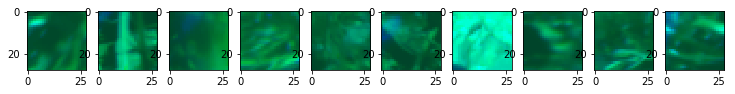

In [2]:
#read movie data sky
def read_movie_from_h5(filename):
    h5f = h5py.File(filename,'r')
    movie_bgr_h5=h5f['movie_bgr_real'][:]
    h5f.close()
    return movie_bgr_h5
movie_bgr_h5=np.concatenate((read_movie_from_h5('Data/all_image_patches_lower_1f_28x28_bg_20200512.h5'),\
                            read_movie_from_h5('Data/all_image_patches_upper_1f_28x28_bg_20200512.h5')),axis=0) 
print (movie_bgr_h5.shape)
#
def img_real2view(img):
    gamma_correction=lambda x:np.power(x,1.0/2.2)
    img_shape=img.shape
    # gray image
    if np.size(img_shape)==2:
        #uint8
        if np.max(img)>1:
            temp_view=np.zeros_like(img,dtype=np.float32)
            temp_view=np.float32(img)/255.0#float32, 1.0
            temp_view=gamma_correction(temp_view)
            temp_view2=np.zeros_like(img,dtype=np.uint8)
            temp_view2=np.uint8(temp_view*255)
            return temp_view2
        #float
        if np.max(img)<2:
            return gamma_correction(img)
    #color image
    if np.size(img_shape)==3:
        #uint8
        if np.max(img)>1:
            temp_view=np.zeros_like(img,dtype=np.float32)
            temp_view=np.float32(img)/255.0#1.0
            temp_view=gamma_correction(temp_view)
            temp_view2=np.zeros_like(img,dtype=np.uint8)
            temp_view2=np.uint8(temp_view*255)#255
            return temp_view2
        #float
        if np.max(img)<2:
            return gamma_correction(img)
#
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=movie_bgr_h5[5000+ii,:,:,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [3]:
#input: X, shape (samplesize*nfeatures)
#output: the specific eigenvectors
def pca_image_crops(X,n_components,seed=99):
    pca = PCA(n_components=n_components, svd_solver='randomized',random_state=seed)
    pca.fit(X)
    eigvecs=[]
    for ii in range(n_components):
        eigvecs.append(pca.components_[ii])
    eigvecs=np.asarray(eigvecs)
    eigvals=pca.explained_variance_ratio_
    return eigvecs,eigvals
def pre_images(images):
    temp2 = images - images.mean(axis=0) #global centering
    temp2 -= temp2.mean(axis=1).reshape(images.shape[0], -1) #local centering
    return temp2
def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix; shape (nfeatures*samplesize)
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    sigma = np.cov(X, rowvar=True) # [M x M]
    U,S,V = np.linalg.svd(sigma)
    epsilon = 1e-8 
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

##  <font color='red'>Upper</font> 

(50000, 9, 9, 2)


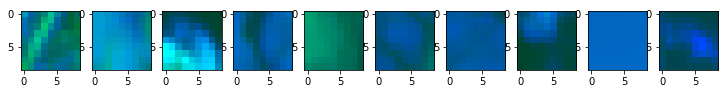

In [4]:
#get 50000 small image crops
num_size=50000
np.random.seed(66)
fnum=np.random.randint(10000,19000,size=num_size)#frame start number
np.random.seed(88)
hnum=np.random.randint(0,28-9,size=num_size)#height start number
np.random.seed(99)
wnum=np.random.randint(0,28-9,size=num_size)#weight start number
#
all_images=[]
for ii in range(num_size):
    all_images.append(movie_bgr_h5[fnum[ii],hnum[ii]:hnum[ii]+9,wnum[ii]:wnum[ii]+9,:])
all_images=np.asarray(all_images)
print (all_images.shape)
#
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp=np.zeros((9,9,3),np.uint8)
    temp[...,1:]=all_images[5000+ii*100,:,:,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)

(50000, 162)
(162, 162)
[6.20248168e-01 7.68628966e-02 6.68500072e-02 5.83344637e-02
 2.05712677e-02 1.89681489e-02 1.38336521e-02 1.06927946e-02
 9.07036000e-03 7.91412354e-03 7.05663468e-03 6.62262214e-03
 4.99558106e-03 4.67684588e-03 4.17708914e-03 4.12745709e-03
 3.32267381e-03 3.26774658e-03 3.22793063e-03 2.64734430e-03
 2.23433258e-03 2.16603569e-03 2.14483715e-03 2.10330420e-03
 2.01992091e-03 1.84397915e-03 1.69710506e-03 1.63207598e-03
 1.58367840e-03 1.38444700e-03 1.32429465e-03 1.25608527e-03
 1.18018436e-03 1.12820816e-03 1.08213351e-03 1.05648589e-03
 9.78048664e-04 9.58862608e-04 8.91331659e-04 8.54783059e-04
 8.29577550e-04 8.26950111e-04 7.96245840e-04 7.15823196e-04
 6.50658663e-04 6.43162016e-04 6.24396158e-04 6.20678459e-04
 5.77289513e-04 5.56091469e-04 5.35355928e-04 5.24574398e-04
 5.17094295e-04 4.94017711e-04 4.50561339e-04 4.42785348e-04
 4.36215978e-04 4.16473717e-04 4.05741210e-04 3.86743734e-04
 3.81989797e-04 3.48994178e-04 3.46951297e-04 3.39858435e-04


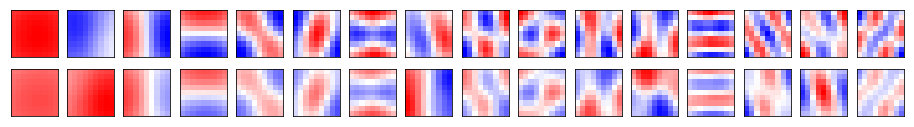

In [5]:
#pca
all_images=np.reshape(all_images,(len(all_images),-1))
if np.max(all_images)>1:
    all_images=all_images/255.0
print (all_images.shape)
eigvecs,eigvals=pca_image_crops(all_images-np.mean(all_images,axis=0,keepdims=True),162)
print (eigvecs.shape)
print (eigvals)
#
#visualize weights
eigvecs=np.reshape(eigvecs,(162,9,9,2))
print (eigvecs.shape)
print (eigvecs[:6,0,0,0])
#
fig, axes = plt.subplots(nrows=2, ncols=16,figsize=(16,2))
for ii in range(16):
    temp=eigvecs[ii]
    vmax=np.max(np.abs(temp[:,:,:]))
    axes[0,ii].imshow(temp[:,:,0],vmax=vmax,vmin=-vmax,cmap='bwr')
    axes[0,ii].set_xticks([])
    axes[0,ii].set_yticks([])
    #vmax=np.max(np.abs(temp[:,:,1]))
    axes[1,ii].imshow(temp[:,:,1],vmax=vmax,vmin=-vmax,cmap='bwr')
    axes[1,ii].set_xticks([])
    axes[1,ii].set_yticks([])

In [7]:
#CC between UV and G weights
print (eigvals)
CCs=np.zeros((len(eigvecs)))
pVs=np.zeros((len(eigvecs)))
for ii in range(len(eigvecs)):
    CCs[ii],pVs[ii]=pearsonr(eigvecs[ii,...,0].flatten(),eigvecs[ii,...,1].flatten())
#
print (CCs)
print (pVs)
opp_ind=np.where(CCs<0)[0].tolist()
pV_ind =np.where(pVs<0.05)[0].tolist()
opp_vP_ind=[opp_ind,pV_ind]
#
opp_pV=set(opp_vP_ind[0]).intersection(*opp_vP_ind)
print (len(opp_pV))
print (opp_pV)
print ([x for x in opp_pV if x<16])
print (np.array([eigvals[x] for x in opp_pV]).sum())

[6.20248168e-01 7.68628966e-02 6.68500072e-02 5.83344637e-02
 2.05712677e-02 1.89681489e-02 1.38336521e-02 1.06927946e-02
 9.07036000e-03 7.91412354e-03 7.05663468e-03 6.62262214e-03
 4.99558106e-03 4.67684588e-03 4.17708914e-03 4.12745709e-03
 3.32267381e-03 3.26774658e-03 3.22793063e-03 2.64734430e-03
 2.23433258e-03 2.16603569e-03 2.14483715e-03 2.10330420e-03
 2.01992091e-03 1.84397915e-03 1.69710506e-03 1.63207598e-03
 1.58367840e-03 1.38444700e-03 1.32429465e-03 1.25608527e-03
 1.18018436e-03 1.12820816e-03 1.08213351e-03 1.05648589e-03
 9.78048664e-04 9.58862608e-04 8.91331659e-04 8.54783059e-04
 8.29577550e-04 8.26950111e-04 7.96245840e-04 7.15823196e-04
 6.50658663e-04 6.43162016e-04 6.24396158e-04 6.20678459e-04
 5.77289513e-04 5.56091469e-04 5.35355928e-04 5.24574398e-04
 5.17094295e-04 4.94017711e-04 4.50561339e-04 4.42785348e-04
 4.36215978e-04 4.16473717e-04 4.05741210e-04 3.86743734e-04
 3.81989797e-04 3.48994178e-04 3.46951297e-04 3.39858435e-04
 3.35683833e-04 3.190295

(50000, 162)
(162, 162)
Symmetrical?: True
(162, 9, 9, 2)
[16.71842548 -3.83034802 -7.06140516  0.28570737  1.10762839  0.15823631]


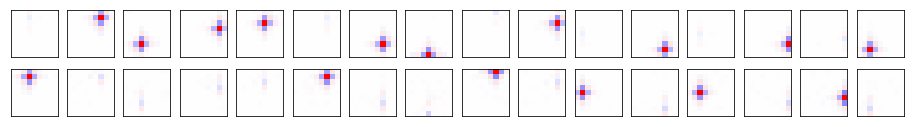

In [8]:
#zca
all_images=np.reshape(all_images,(len(all_images),-1))
if np.max(all_images)>1:
    all_images=all_images/255.0
print (all_images.shape)
eigvecs=zca_whitening_matrix((all_images-np.mean(all_images,axis=0,keepdims=True)).T)
print (eigvecs.shape)
print ('Symmetrical?: {}'.format(np.all(np.abs(eigvecs-eigvecs.T) < 1e-8)))
#
#visualize weights,
eigvecs=np.reshape(eigvecs,(162,9,9,2))
print (eigvecs.shape)
print (eigvecs[:6,0,0,0])
#
np.random.seed(22)
nums=np.random.choice(len(eigvecs),16,replace=False)
fig, axes = plt.subplots(nrows=2, ncols=16,figsize=(16,2))
for ii in range(16):
    temp=eigvecs[nums[ii]]
    vmax=np.max(np.abs(temp[:,:,:]))
    axes[0,ii].imshow(temp[:,:,0],vmax=vmax,vmin=-vmax,cmap='bwr')
    axes[0,ii].set_xticks([])
    axes[0,ii].set_yticks([])
    axes[1,ii].imshow(temp[:,:,1],vmax=vmax,vmin=-vmax,cmap='bwr')
    axes[1,ii].set_xticks([])
    axes[1,ii].set_yticks([])


In [9]:
#CC between UV and G weights
CCs=np.zeros((len(eigvecs)))
pVs=np.zeros((len(eigvecs)))
for ii in range(len(eigvecs)):
    CCs[ii],pVs[ii]=pearsonr(eigvecs[ii,...,0].flatten(),eigvecs[ii,...,1].flatten())
#
print (CCs)
print (pVs)
opp_ind=np.where(CCs<0)[0].tolist()
pV_ind =np.where(pVs<0.05)[0].tolist()
opp_vP_ind=[opp_ind,pV_ind]
opp_pV=set(opp_vP_ind[0]).intersection(*opp_vP_ind)
print (len(opp_pV))
print (opp_pV)

[-0.93212653 -0.64415112 -0.86251632 -0.62176558 -0.86362572 -0.58962752
 -0.87122825 -0.60283781 -0.89973361 -0.66299651 -0.8862356  -0.71382076
 -0.8634895  -0.60796436 -0.89447851 -0.652329   -0.93041808 -0.77825283
 -0.86714461 -0.51904791 -0.74113888 -0.56415001 -0.77843458 -0.51373815
 -0.78395359 -0.592236   -0.84233082 -0.56434805 -0.83423623 -0.69612893
 -0.80093761 -0.59115057 -0.85029486 -0.62400579 -0.88652902 -0.69424512
 -0.67091854 -0.53006469 -0.55865039 -0.52349735 -0.58496011 -0.41253039
 -0.62279535 -0.50106143 -0.58832308 -0.51082337 -0.6816248  -0.57572084
 -0.66120694 -0.611513   -0.68142598 -0.60764222 -0.72398171 -0.68289185
 -0.56761629 -0.52585013 -0.53583659 -0.5484451  -0.48830792 -0.50783511
 -0.58914253 -0.61370807 -0.55925209 -0.59010095 -0.60783738 -0.48892153
 -0.62362301 -0.62986825 -0.61916535 -0.69157283 -0.67919626 -0.6917991
 -0.57481364 -0.52902788 -0.53849123 -0.55086101 -0.50272241 -0.55913431
 -0.59166298 -0.59767132 -0.51801935 -0.52768652 -0.

##  <font color='red'>Lower</font> 

(50000, 9, 9, 2)


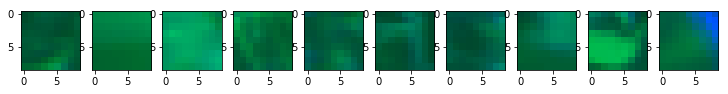

In [10]:
#get 50000 small image crops (9x9 pixels)
num_size=50000
np.random.seed(66)
fnum=np.random.randint(0,9000,size=num_size)#frame start number
np.random.seed(88)
hnum=np.random.randint(0,28-9,size=num_size)#height start number
np.random.seed(99)
wnum=np.random.randint(0,28-9,size=num_size)#weight start number
#
all_images=[]
for ii in range(num_size):
    all_images.append(movie_bgr_h5[fnum[ii],hnum[ii]:hnum[ii]+9,wnum[ii]:wnum[ii]+9,:])
all_images=np.asarray(all_images)
print (all_images.shape)
#
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp=np.zeros((9,9,3),np.uint8)
    temp[...,1:]=all_images[5000+ii*100,:,:,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)

(50000, 162)
(162, 162)
[7.81985312e-01 4.33036831e-02 3.21951841e-02 2.94342210e-02
 1.52664510e-02 1.33306673e-02 8.87563385e-03 6.83734985e-03
 6.24928095e-03 5.52118610e-03 5.10634019e-03 3.47416037e-03
 3.44583326e-03 3.23034953e-03 3.05764238e-03 2.67920371e-03
 2.13639856e-03 1.82738481e-03 1.78879078e-03 1.65939424e-03
 1.48754763e-03 1.40067048e-03 1.27387738e-03 1.22183837e-03
 1.10679071e-03 9.89631319e-04 9.02310074e-04 8.76901477e-04
 8.52567127e-04 7.84963021e-04 7.28936815e-04 6.47702692e-04
 6.39968284e-04 5.57035735e-04 5.44407797e-04 5.33981207e-04
 5.23395329e-04 5.17438040e-04 4.97545092e-04 4.49807993e-04
 4.22336036e-04 4.10745601e-04 4.03881584e-04 3.94127079e-04
 3.72814218e-04 3.69327516e-04 3.08330527e-04 3.02701781e-04
 2.94319951e-04 2.88713065e-04 2.72433465e-04 2.61990108e-04
 2.56762848e-04 2.49579924e-04 2.42549536e-04 2.34893808e-04
 2.27024914e-04 2.22154782e-04 2.01706059e-04 1.96937371e-04
 1.90158663e-04 1.84499224e-04 1.81140780e-04 1.77780069e-04


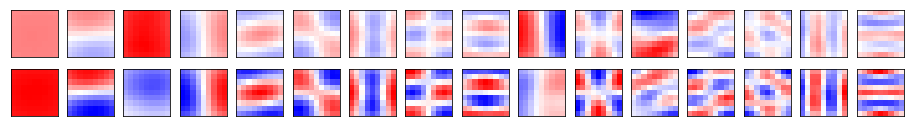

In [11]:
#pca
all_images=np.reshape(all_images,(len(all_images),-1))
if np.max(all_images)>1:
    all_images=all_images/255.0
print (all_images.shape)
eigvecs,eigvals=pca_image_crops(all_images-np.mean(all_images,axis=0,keepdims=True),162)
print (eigvecs.shape)
print (eigvals)
#
#visualize weights
eigvecs=np.reshape(eigvecs,(162,9,9,2))
print (eigvecs.shape)
print (eigvecs[:6,0,0,0])
#
fig, axes = plt.subplots(nrows=2, ncols=16,figsize=(16,2))
for ii in range(16):
    temp=eigvecs[ii]
    vmax=np.max(np.abs(temp[:,:,:]))
    axes[0,ii].imshow(temp[:,:,0],vmax=vmax,vmin=-vmax,cmap='bwr')
    axes[0,ii].set_xticks([])
    axes[0,ii].set_yticks([])
    axes[1,ii].imshow(temp[:,:,1],vmax=vmax,vmin=-vmax,cmap='bwr')
    axes[1,ii].set_xticks([])
    axes[1,ii].set_yticks([])

In [13]:
#CC between UV and G weights
print (eigvals)
CCs=np.zeros((len(eigvecs)))
pVs=np.zeros((len(eigvecs)))
for ii in range(len(eigvecs)):
    CCs[ii],pVs[ii]=pearsonr(eigvecs[ii,...,0].flatten(),eigvecs[ii,...,1].flatten())
#
print (CCs)
print (pVs)
opp_ind=np.where(CCs<0)[0].tolist()
pV_ind =np.where(pVs<0.05)[0].tolist()
opp_vP_ind=[opp_ind,pV_ind]
opp_pV=set(opp_vP_ind[0]).intersection(*opp_vP_ind)
print (len(opp_pV))
print (opp_pV)
print ([x for x in opp_pV if x<16])
print (np.array([eigvals[x] for x in opp_pV]).sum())

[7.81985312e-01 4.33036831e-02 3.21951841e-02 2.94342210e-02
 1.52664510e-02 1.33306673e-02 8.87563385e-03 6.83734985e-03
 6.24928095e-03 5.52118610e-03 5.10634019e-03 3.47416037e-03
 3.44583326e-03 3.23034953e-03 3.05764238e-03 2.67920371e-03
 2.13639856e-03 1.82738481e-03 1.78879078e-03 1.65939424e-03
 1.48754763e-03 1.40067048e-03 1.27387738e-03 1.22183837e-03
 1.10679071e-03 9.89631319e-04 9.02310074e-04 8.76901477e-04
 8.52567127e-04 7.84963021e-04 7.28936815e-04 6.47702692e-04
 6.39968284e-04 5.57035735e-04 5.44407797e-04 5.33981207e-04
 5.23395329e-04 5.17438040e-04 4.97545092e-04 4.49807993e-04
 4.22336036e-04 4.10745601e-04 4.03881584e-04 3.94127079e-04
 3.72814218e-04 3.69327516e-04 3.08330527e-04 3.02701781e-04
 2.94319951e-04 2.88713065e-04 2.72433465e-04 2.61990108e-04
 2.56762848e-04 2.49579924e-04 2.42549536e-04 2.34893808e-04
 2.27024914e-04 2.22154782e-04 2.01706059e-04 1.96937371e-04
 1.90158663e-04 1.84499224e-04 1.81140780e-04 1.77780069e-04
 1.69154645e-04 1.609900

(50000, 162)
(162, 162)
Symmetrical?: True
(162, 9, 9, 2)
[ 3.80103523e+01 -5.48362852e+00 -1.94517197e+01  1.60270627e+00
  3.70426974e+00 -2.46077373e-02]


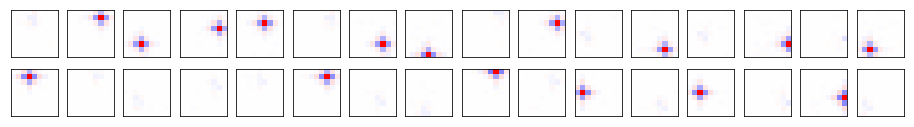

In [14]:
#zca
all_images=np.reshape(all_images,(len(all_images),-1))
if np.max(all_images)>1:
    all_images=all_images/255.0
print (all_images.shape)
eigvecs=zca_whitening_matrix((all_images-np.mean(all_images,axis=0,keepdims=True)).T)
print (eigvecs.shape)
print ('Symmetrical?: {}'.format(np.all(np.abs(eigvecs-eigvecs.T) < 1e-8)))
#
#visualize weights,
eigvecs=np.reshape(eigvecs,(162,9,9,2))
print (eigvecs.shape)
print (eigvecs[:6,0,0,0])
#
np.random.seed(22)
nums=np.random.choice(len(eigvecs),16,replace=False)
fig, axes = plt.subplots(nrows=2, ncols=16,figsize=(16,2))
for ii in range(16):
    temp=eigvecs[nums[ii]]
    vmax=np.max(np.abs(temp[:,:,:]))
    axes[0,ii].imshow(temp[:,:,0],vmax=vmax,vmin=-vmax,cmap='bwr')
    axes[0,ii].set_xticks([])
    axes[0,ii].set_yticks([])
    axes[1,ii].imshow(temp[:,:,1],vmax=vmax,vmin=-vmax,cmap='bwr')
    axes[1,ii].set_xticks([])
    axes[1,ii].set_yticks([])

In [15]:
#CC between UV and G weights
CCs=np.zeros((len(eigvecs)))
pVs=np.zeros((len(eigvecs)))
for ii in range(len(eigvecs)):
    CCs[ii],pVs[ii]=pearsonr(eigvecs[ii,...,0].flatten(),eigvecs[ii,...,1].flatten())
#
print (CCs)
print (pVs)
opp_ind=np.where(CCs<0)[0].tolist()
pV_ind =np.where(pVs<0.05)[0].tolist()
opp_vP_ind=[opp_ind,pV_ind]
opp_pV=set(opp_vP_ind[0]).intersection(*opp_vP_ind)
print (len(opp_pV))
print (opp_pV)

[-0.93723645 -0.55252379 -0.55213172 -0.32612726 -0.11105245 -0.25523793
 -0.04872644 -0.20507962 -0.0971707  -0.20519052 -0.1742947  -0.24490685
 -0.28125359 -0.31177575 -0.40677661 -0.61460257 -0.67414201 -0.89042357
 -0.81165138 -0.52631147 -0.52731862 -0.35691206 -0.21259389 -0.27187165
 -0.23554987 -0.27795108 -0.38804536 -0.28493055 -0.20660122 -0.19882132
 -0.21944526 -0.19516737 -0.3559646  -0.46107331 -0.64896176 -0.84764191
 -0.76730304 -0.54057393 -0.61904167 -0.42126628 -0.27114089 -0.33887753
 -0.40872284 -0.35610825 -0.37897066 -0.28998117 -0.32340664 -0.27976479
 -0.41648307 -0.33339407 -0.41341008 -0.54146958 -0.54023239 -0.84702872
 -0.74857832 -0.54065088 -0.58436381 -0.40945341 -0.40407244 -0.35241826
 -0.26932149 -0.23007476 -0.29776522 -0.20160693 -0.36050598 -0.31840425
 -0.42342816 -0.37797823 -0.44347819 -0.50454123 -0.60140999 -0.77938262
 -0.74817457 -0.58769285 -0.60341671 -0.48407725 -0.38675862 -0.3521274
 -0.28090715 -0.20910533 -0.28565629 -0.26487413 -0.